<a href="https://colab.research.google.com/github/rexwotan-A01840088/Ciencia-y-Analitica-de-datos/blob/main/Actividad6FE_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC5053 - Ciencia y analítica de datos**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

**Semana 6**
Ingeniería de características (FE)

---

*   NOMBRE: Rex Wotan Dominguez Chang
*   MATRÍCULA: A01840088
*   NOMBRE: Sofía Donlucas Bañuelos
*   MATRÍCULA: A01655565
*   NOMBRE: Gerardo Duarte Ceballos
*   MATRÍCULA: A01273069

En esta actividad trabajarás con el archivo `computer_prices.csv`, basado en un conjunto de datos sobre características técnicas y especificaciones de computadoras portátiles y de escritorio, disponible en Kaggle.

Los datos fueron recopilados para analizar el rendimiento y el precio de los dispositivos, e incluyen información sobre hardware, almacenamiento, conectividad y otras especificaciones técnicas. Los indicadores incluidos son:

* `device_type`: Tipo de dispositivo (ej. laptop, desktop)
* `brand`: Marca del dispositivo
* `model`: Modelo del dispositivo
* `release_year`: Año de lanzamiento del dispositivo
* `os`: Sistema operativo instalado
* `form_factor`: Factor de forma o diseño del dispositivo (ej. laptop, ultrabook, desktop tower)
* `cpu_brand`: Marca del procesador
* `cpu_tier`: Nivel o gama del procesador, ordinal del 1 al 6 según desempeño
* `cpu_cores`: Número de núcleos del procesador
* `cpu_threads`: Número de hilos de ejecución del procesador
* `gpu_brand`: Marca de la tarjeta gráfica
* `gpu_model`: Modelo específico de la tarjeta gráfica
* `gpu_tier`: Nivel o gama de la GPU, ordinal del 1 al 6 según desempeño
* `vram_gb`: Memoria de video de la GPU en gigabytes
* `ram_gb`: Memoria RAM del dispositivo en gigabytes
* `storage_type`: Tipo de almacenamiento (ej. HDD, SSD)
* `storage_gb`: Capacidad de almacenamiento en gigabytes
* `storage_drive_count`: Número de unidades de almacenamiento instaladas
* `display_type`: Tipo de pantalla (ej. IPS, TN, OLED)
* `charger_watts`: Potencia del cargador (en watts) para laptops
* `psu_watts`: Potencia de la fuente de poder (en watts) para desktops
* `wifi`: Estándar de conectividad Wi-Fi (ej. Wi-Fi 5, 6, 6E, 7)
* `bluetooth`: Versión de Bluetooth
* `weight_kg`: Peso del dispositivo en kilogramos
* `warranty_months`: Meses de garantía del dispositivo
* `price`: Precio del dispositivo. Es la variable de salida o *target*, es decir, la que se pretende predecir más adelante al construir el modelo.

**NOTA IMPORTANTE:** Asegúrate de responder *explícitamente* todos los cuestionamientos.

In [1]:
# Instalar las bibliotecas necesarias
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [2]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy.stats import probplot
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders.binary import BinaryEncoder

1. Descarga el archivo: `computer_prices.csv` y guarda, en un dataframe (`compu_df`), todos sus registros.
* Utiliza el método `info()` del dataframe, para obtener el resumen de los tipos de datos. ¿Cuántas columnas son numéricas y cuántas de texto?
* Determina la cantidad de valores únicos por columna.
* Elimina las variables:
  * `model`: Debido a su altísima cardinalidad, lo que dificulta su uso en análisis y modelado.
  * `cpu_model`: Además de su elevada cardinalidad, su información ya está representada de manera implícita en otras variables como: `cpu_tier`, `cpu_cores` y `cpu_threads`

In [4]:
import os
import io
import pandas as pd
import numpy as np

def cargar_computer_prices():
    posibles_rutas = ["computer_prices.csv", "/content/computer_prices.csv"]
    ruta_encontrada = None
    for p in posibles_rutas:
        if os.path.exists(p):
            ruta_encontrada = p
            break

    if ruta_encontrada is not None:
        try:
            df = pd.read_csv(ruta_encontrada, encoding="utf-8-sig",
                             low_memory=False, on_bad_lines="skip")
        except UnicodeDecodeError:
            df = pd.read_csv(ruta_encontrada, encoding="latin-1",
                             low_memory=False, on_bad_lines="skip")
        return df, ruta_encontrada
    else:
        return None, None # Return None if file not found

compu_df, ruta = cargar_computer_prices()

if compu_df is None:
    print("❌ Error: No se encontró el archivo 'computer_prices.csv'. Asegúrate de que esté en el directorio correcto o cárgalo.")
else:
    print(f"✅ Archivo 'computer_prices.csv' cargado desde: {ruta}")
    print("=== Resumen de tipos (DataFrame.info) ===")
    compu_df.info(memory_usage="deep")

    num_cols  = compu_df.select_dtypes(include=np.number).columns
    text_cols = compu_df.select_dtypes(include=["object", "string", "category"]).columns
    dt_cols   = compu_df.select_dtypes(include=["datetime64[ns]", "datetimetz"]).columns
    bool_cols = compu_df.select_dtypes(include=["bool"]).columns

    print("\n=== Conteo por tipo lógico ===")
    print(f"Columnas numéricas: {len(num_cols)}")
    print(f"Columnas de texto (object/string/category): {len(text_cols)}")
    print(f"Columnas datetime: {len(dt_cols)}")
    print(f"Columnas booleanas: {len(bool_cols)}\n")

    unique_counts = compu_df.nunique(dropna=True).sort_values(ascending=False)
    print("=== Valores únicos por columna (excluye NaN) ===")
    print(unique_counts.to_string())
    print()

    cols_a_eliminar = [c for c in ["model", "gpu_model"] if c in compu_df.columns]
    compu_df.drop(columns=cols_a_eliminar, inplace=True, errors="ignore")

    if cols_a_eliminar:
        print(f"🗑️ Columnas eliminadas: {cols_a_eliminar}")
    else:
        print("ℹ️ Las columnas 'model' y/o 'cpu_model' no estaban presentes.")

    print(f"🔁 Nuevo shape tras eliminación: {compu_df.shape[0]} filas × {compu_df.shape[1]} columnas\n")

✅ Archivo 'computer_prices.csv' cargado desde: computer_prices.csv
=== Resumen de tipos (DataFrame.info) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   device_type          100000 non-null  object 
 1   brand                100000 non-null  object 
 2   model                100000 non-null  object 
 3   release_year         100000 non-null  int64  
 4   os                   100000 non-null  object 
 5   form_factor          100000 non-null  object 
 6   cpu_brand            100000 non-null  object 
 7   cpu_model            100000 non-null  object 
 8   cpu_tier             100000 non-null  int64  
 9   cpu_cores            100000 non-null  int64  
 10  cpu_threads          100000 non-null  int64  
 11  gpu_brand            100000 non-null  object 
 12  gpu_model            100000 non-null  object 
 13  gpu_tier   

2. Antes de iniciar con el análisis univariado, verifica si hay valores duplicados y/o faltantes.
* Obtén las estadísticas descriptivas, separado las numéricas y las categóricas. De estas últimas incluye las tablas de frecuencia.
* Genera histogramas para las numéricas y diagramas de barras para las categóricas. Con alta cardinalidad, sólo incluye los 10 valores más frecuentes.

✅ compu_df listo. Shape: 100000 filas × 25 columnas
🗑️ Columnas eliminadas: ['cpu_model']

🔎 Filas duplicadas (completas): 0

=== Resumen de faltantes por columna ===


,mensaje
0,No hay valores faltantes.



=== Columnas numéricas ===
['release_year', 'cpu_tier', 'cpu_cores', 'cpu_threads', 'gpu_tier', 'vram_gb', 'ram_gb', 'storage_gb', 'storage_drive_count', 'charger_watts', 'psu_watts', 'bluetooth', 'weight_kg', 'warranty_months', 'price']

=== Columnas categóricas ===
['device_type', 'brand', 'os', 'form_factor', 'cpu_brand', 'gpu_brand', 'storage_type', 'display_type', 'wifi']

📊 Estadísticas descriptivas (numéricas)


,count,mean,std,min,25%,50%,75%,max,p1,p5,p95,p99,n_faltantes
release_year,100000.0,2022.320850,2.025761,2018.00,2021.00,2023.00,2024.00,2025.00,2018.00,2018.00,2025.00,2025.00,0
cpu_tier,100000.0,3.153490,1.373175,1.00,2.00,3.00,4.00,6.00,1.00,1.00,5.00,6.00,0
cpu_cores,100000.0,10.515740,5.044092,4.00,6.00,8.00,14.00,28.00,4.00,4.00,20.00,26.00,0
cpu_threads,100000.0,19.372700,9.718426,4.00,12.00,16.00,24.00,56.00,6.00,8.00,36.00,52.00,0
gpu_tier,100000.0,2.991350,1.459643,1.00,2.00,3.00,4.00,6.00,1.00,1.00,6.00,6.00,0
vram_gb,100000.0,6.152180,3.964926,0.00,4.00,6.00,8.00,16.00,0.00,0.00,12.00,16.00,0
ram_gb,100000.0,39.706400,31.902684,8.00,16.00,32.00,64.00,144.00,8.00,8.00,96.00,128.00,0
storage_gb,100000.0,903.936000,774.243654,256.00,512.00,512.00,1024.00,4096.00,256.00,256.00,2048.00,4096.00,0
storage_drive_count,100000.0,1.524980,0.797284,1.00,1.00,1.00,2.00,4.00,1.00,1.00,3.00,4.00,0
charger_watts,100000.0,61.383450,62.795034,0.00,0.00,65.00,90.00,240.00,0.00,0.00,180.00,240.00,0



📊 Estadísticas descriptivas (categóricas)


,count,unique,top,freq
device_type,100000,2,Laptop,59844
brand,100000,10,Lenovo,15992
os,100000,4,Windows,71817
form_factor,100000,10,Mainstream,17819
cpu_brand,100000,3,Intel,52774
gpu_brand,100000,4,NVIDIA,54712
storage_type,100000,4,NVMe,45059
display_type,100000,6,LED,32000
wifi,100000,4,Wi-Fi 6,46149



📋 Tablas de frecuencia por variable categórica

— device_type (niveles: 2)


,device_type,frecuencia,proporcion
0,Laptop,59844,0.5984
1,Desktop,40156,0.4016



— brand (niveles: 10)


,brand,frecuencia,proporcion
0,Lenovo,15992,0.1599
1,HP,14114,0.1411
2,Dell,14005,0.14
3,Apple,11915,0.1192
4,ASUS,10159,0.1016
5,Acer,9925,0.0992
6,Samsung,8066,0.0807
7,MSI,7891,0.0789
8,Gigabyte,4900,0.049
9,Razer,3033,0.0303



— os (niveles: 4)


,os,frecuencia,proporcion
0,Windows,71817,0.7182
1,macOS,18207,0.1821
2,Linux,6109,0.0611
3,ChromeOS,3867,0.0387



— form_factor (niveles: 10)


,form_factor,frecuencia,proporcion
0,Mainstream,17819,0.1782
1,Gaming,16876,0.1688
2,ATX,15597,0.156
3,Ultrabook,13236,0.1324
4,Micro-ATX,8672,0.0867
5,Full-Tower,7110,0.0711
6,2-in-1,7049,0.0705
7,SFF,5585,0.0558
8,Workstation,4864,0.0486
9,Mini-ITX,3192,0.0319



— cpu_brand (niveles: 3)


,cpu_brand,frecuencia,proporcion
0,Intel,52774,0.5277
1,AMD,35311,0.3531
2,Apple,11915,0.1192



— gpu_brand (niveles: 4)


,gpu_brand,frecuencia,proporcion
0,NVIDIA,54712,0.5471
1,Apple,18922,0.1892
2,AMD,15767,0.1577
3,Intel,10599,0.106



— storage_type (niveles: 4)


,storage_type,frecuencia,proporcion
0,NVMe,45059,0.4506
1,SSD,24937,0.2494
2,HDD,15023,0.1502
3,Hybrid,14981,0.1498



— display_type (niveles: 6)


,display_type,frecuencia,proporcion
0,LED,32000,0.32
1,OLED,21910,0.2191
2,IPS,17742,0.1774
3,Mini-LED,12188,0.1219
4,QLED,10069,0.1007
5,VA,6091,0.0609



— wifi (niveles: 4)


,wifi,frecuencia,proporcion
0,Wi-Fi 6,46149,0.4615
1,Wi-Fi 6E,25923,0.2592
2,Wi-Fi 5,19926,0.1993
3,Wi-Fi 7,8002,0.08


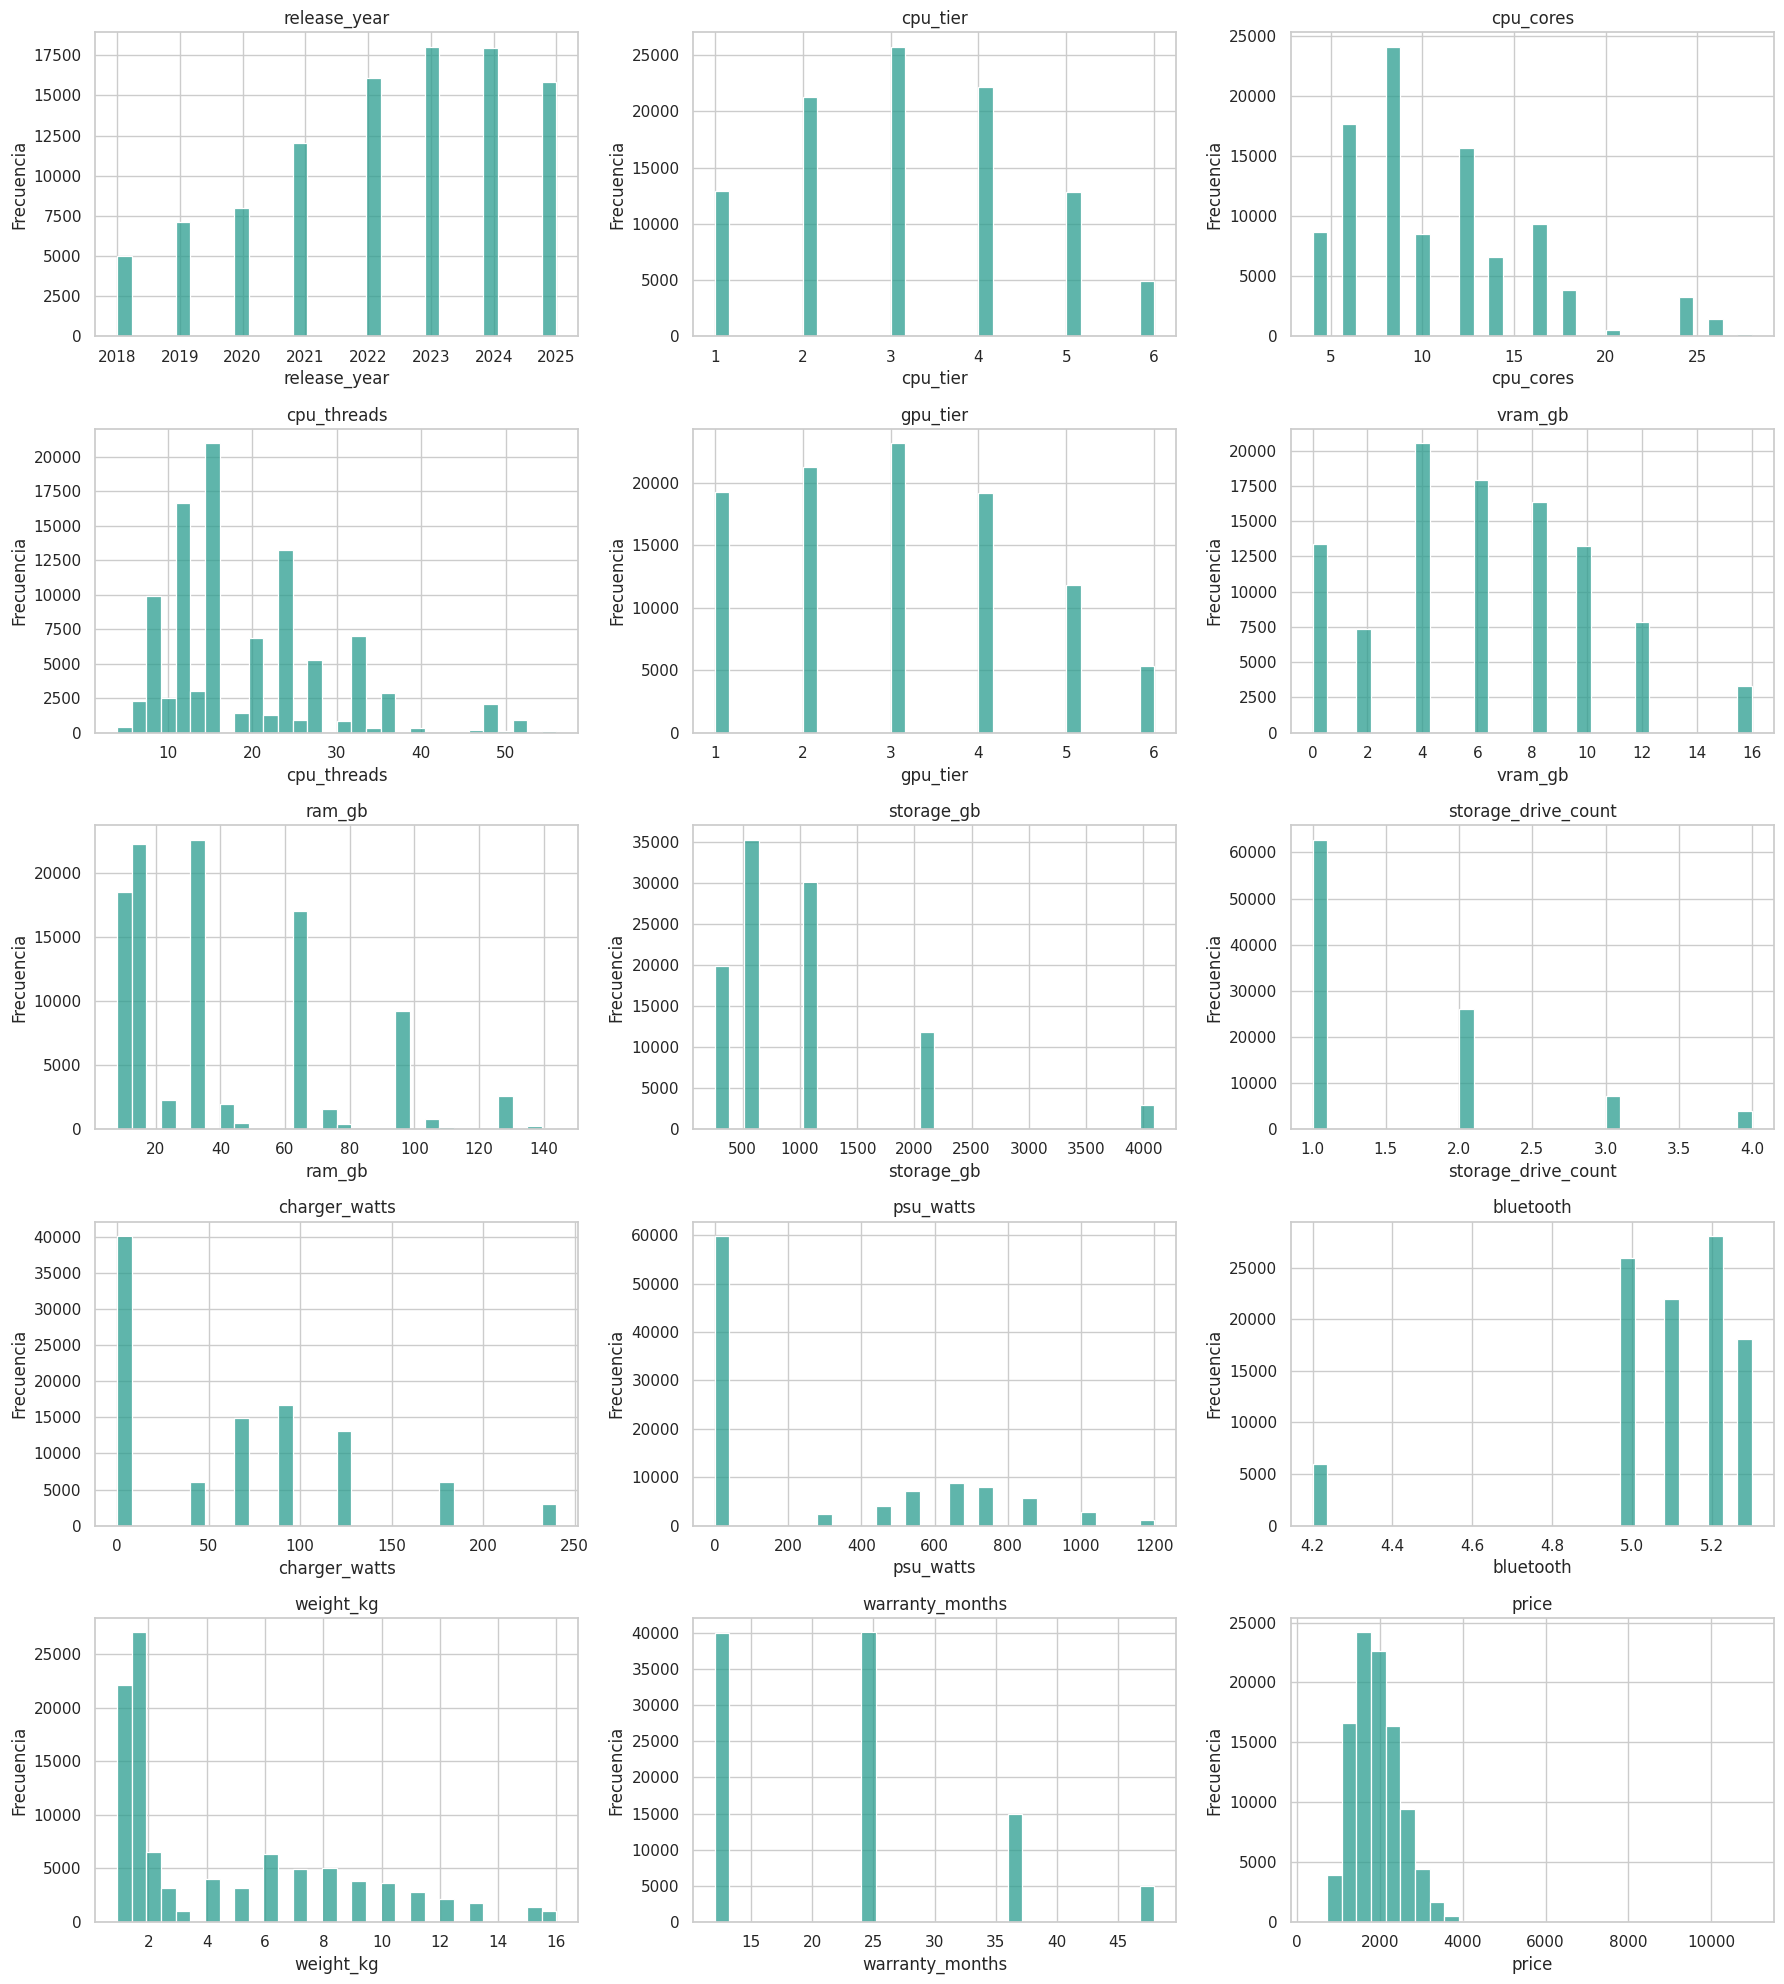

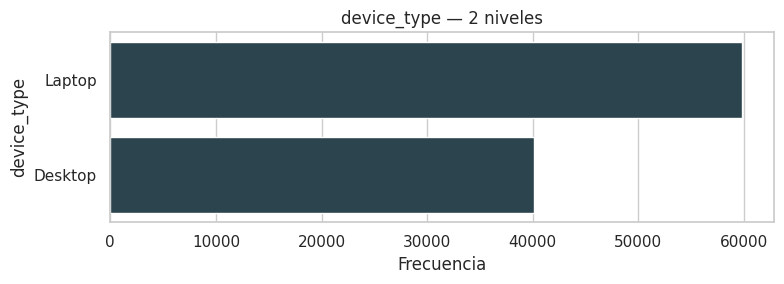

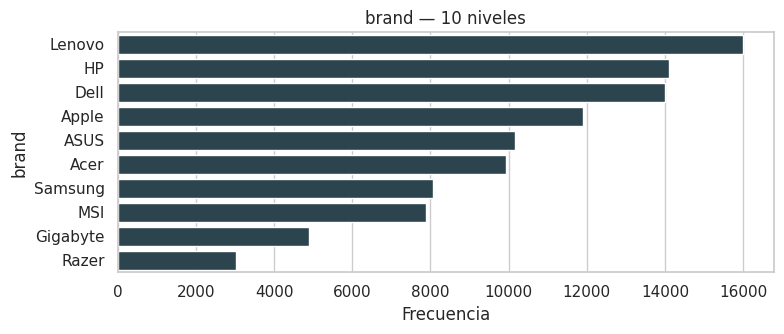

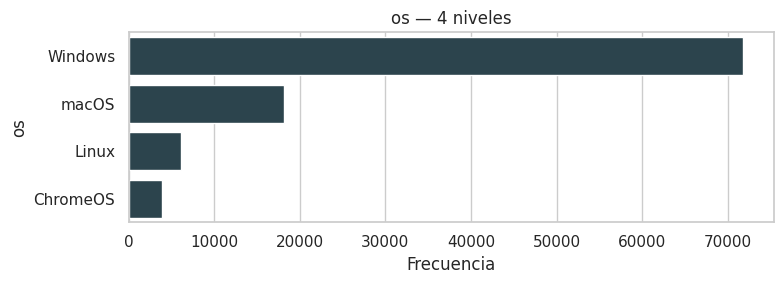

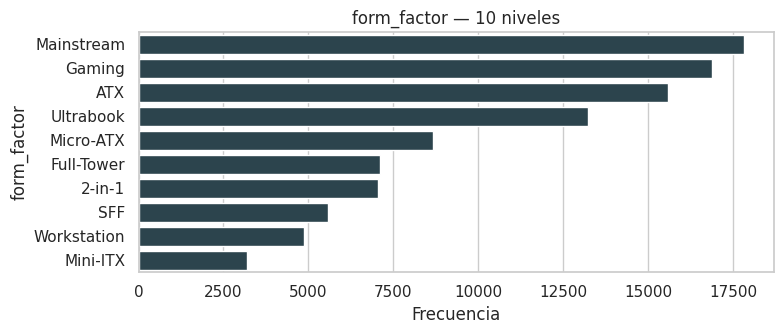

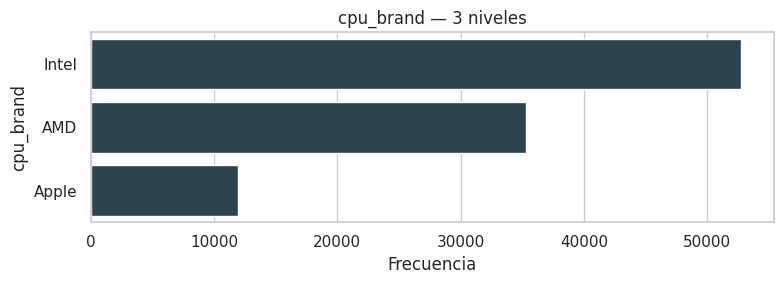

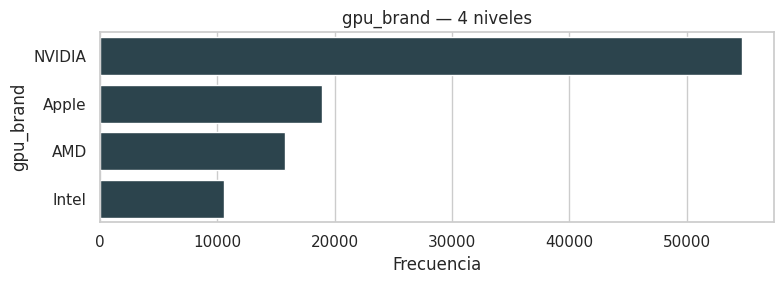

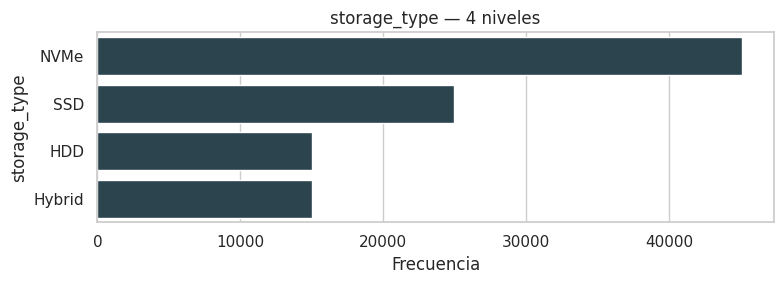

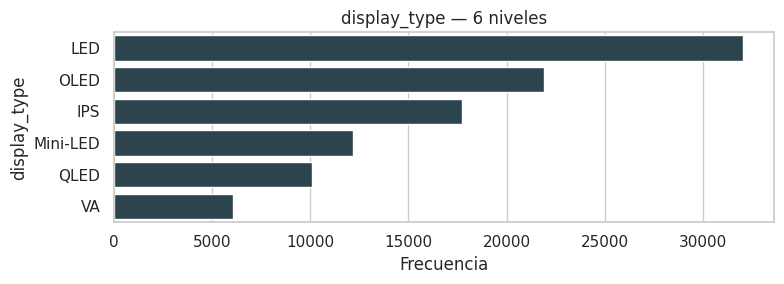

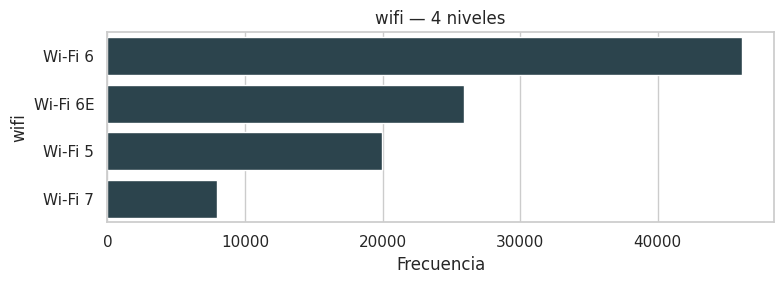


✅ Análisis univariado preliminar completado (duplicados, faltantes, descriptivos y visualizaciones).


In [5]:
import os
import io
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if 'compu_df' not in globals():
    posibles_rutas = ["computer_prices.csv", "/content/computer_prices.csv"]
    ruta = next((p for p in posibles_rutas if os.path.exists(p)), None)

    if ruta is None:
        try:
            from google.colab import files
            print("No se encontró 'computer_prices.csv'. Sube el archivo cuando se abra el diálogo.")
            uploaded = files.upload()
            if "computer_prices.csv" in uploaded:
                raw = uploaded["computer_prices.csv"]
                nombre = "computer_prices.csv"
            else:
                nombre = next(iter(uploaded.keys()))
                raw = uploaded[nombre]
                print(f"⚠️ No se encontró 'computer_prices.csv'; usando: {nombre}")
            try:
                compu_df = pd.read_csv(io.BytesIO(raw), encoding="utf-8-sig",
                                       low_memory=False, on_bad_lines="skip")
            except UnicodeDecodeError:
                compu_df = pd.read_csv(io.BytesIO(raw), encoding="latin-1",
                                       low_memory=False, on_bad_lines="skip")
        except ImportError:
            raise RuntimeError("Ejecuta esto en Colab o asegura que 'computer_prices.csv' exista en el directorio.")
    else:
        try:
            compu_df = pd.read_csv(ruta, encoding="utf-8-sig",
                                   low_memory=False, on_bad_lines="skip")
        except UnicodeDecodeError:
            compu_df = pd.read_csv(ruta, encoding="latin-1",
                                   low_memory=False, on_bad_lines="skip")

print(f"✅ compu_df listo. Shape: {compu_df.shape[0]} filas × {compu_df.shape[1]} columnas")


cols_a_eliminar = [c for c in ["model", "cpu_model"] if c in compu_df.columns]
if cols_a_eliminar:
    compu_df.drop(columns=cols_a_eliminar, inplace=True, errors="ignore")
    print(f"🗑️ Columnas eliminadas: {cols_a_eliminar}")
else:
    print("ℹ️ 'model' y/o 'cpu_model' no estaban presentes (nada que eliminar).")


dup_total = compu_df.duplicated().sum()
print(f"\n🔎 Filas duplicadas (completas): {dup_total}")
if dup_total > 0:
    print("   Sugerencia: compu_df = compu_df.drop_duplicates().")

missing_counts = compu_df.isna().sum()
missing_pct = (missing_counts / len(compu_df) * 100).round(2)
missing_summary = pd.DataFrame({
    "faltantes": missing_counts,
    "%_faltantes": missing_pct
}).sort_values(by="faltantes", ascending=False)

print("\n=== Resumen de faltantes por columna ===")
display(missing_summary[missing_summary["faltantes"] > 0] if missing_summary["faltantes"].sum() > 0 else
        pd.DataFrame({"mensaje": ["No hay valores faltantes."]}))


num_cols  = compu_df.select_dtypes(include=np.number).columns.tolist()
cat_cols  = compu_df.select_dtypes(include=["object", "string", "category"]).columns.tolist()

print("\n=== Columnas numéricas ===")
print(num_cols if num_cols else "No se hallaron columnas numéricas.")
print("\n=== Columnas categóricas ===")
print(cat_cols if cat_cols else "No se hallaron columnas categóricas.")


if num_cols:
    desc_num = compu_df[num_cols].describe().T
    percentiles = compu_df[num_cols].quantile([0.01, 0.05, 0.95, 0.99]).T
    percentiles.columns = [f"p{int(p*100)}" for p in [0.01, 0.05, 0.95, 0.99]]
    n_miss = compu_df[num_cols].isna().sum().rename("n_faltantes")
    desc_num = desc_num.join(percentiles, how="left").join(n_miss, how="left")
    print("\n📊 Estadísticas descriptivas (numéricas)")
    display(desc_num)

if cat_cols:

    desc_cat = compu_df[cat_cols].describe().T  # count, unique, top, freq
    print("\n📊 Estadísticas descriptivas (categóricas)")
    display(desc_cat)


    print("\n📋 Tablas de frecuencia por variable categórica")
    freq_tables = {}
    high_card_threshold = 15   # si supera este umbral, mostramos solo Top-N
    top_n = 10

    for col in cat_cols:
        vc = compu_df[col].astype("string").fillna("<NA>").value_counts(dropna=False)
        total = vc.sum()
        nunique = vc.size
        if nunique > high_card_threshold:
            vc_display = vc.head(top_n)
            title_suffix = f"(alta cardinalidad: {nunique} niveles, mostrando Top {top_n})"
        else:
            vc_display = vc
            title_suffix = f"(niveles: {nunique})"

        freq_df = pd.DataFrame({
            col: vc_display.index,
            "frecuencia": vc_display.values,
            "proporcion": (vc_display.values / total).round(4)
        })
        freq_tables[col] = freq_df

        print(f"\n— {col} {title_suffix}")
        display(freq_df)

sns.set(style="whitegrid")

if num_cols:
    n = len(num_cols)
    ncols = 3
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
    axes = np.array(axes).reshape(nrows, ncols)

    for i, col in enumerate(num_cols):
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        data = compu_df[col].dropna()

        if data.size == 0 or data.nunique() <= 1:
            ax.text(0.5, 0.5, "Sin variación / sin datos", ha="center", va="center")
            ax.set_title(col)
            ax.axis("off")
            continue
        sns.histplot(data, bins=30, kde=False, ax=ax, color="#2a9d8f")
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel("Frecuencia")

    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

if cat_cols:
    top_n = 10
    high_card_threshold = 15
    for col in cat_cols:
        vc = compu_df[col].astype("string").fillna("<NA>").value_counts(dropna=False)
        nunique = vc.size
        if nunique > high_card_threshold:
            vc_plot = vc.head(top_n)
            titulo = f"{col} — Top {top_n} de {nunique} niveles"
        else:
            vc_plot = vc
            titulo = f"{col} — {nunique} niveles"

        plt.figure(figsize=(8, max(3, min(0.35*len(vc_plot), 10))))
        sns.barplot(x=vc_plot.values, y=vc_plot.index, orient="h", color="#264653")
        plt.title(titulo)
        plt.xlabel("Frecuencia")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

print("\n✅ Análisis univariado preliminar completado (duplicados, faltantes, descriptivos y visualizaciones).")

3. Dibuja un mapa de calor con la matriz de correlación para las variables numéricas del conjunto de datos.
* Identifica los pares de variables cuya correlación sea superior a 0.9 e imprímelos.
* Reflexiona sobre cuáles variables representan de manera general la capacidad del hardware y mantenlas; elimina las demás por aportar información redundante.
* Incluye una breve justificación de tus decisiones.

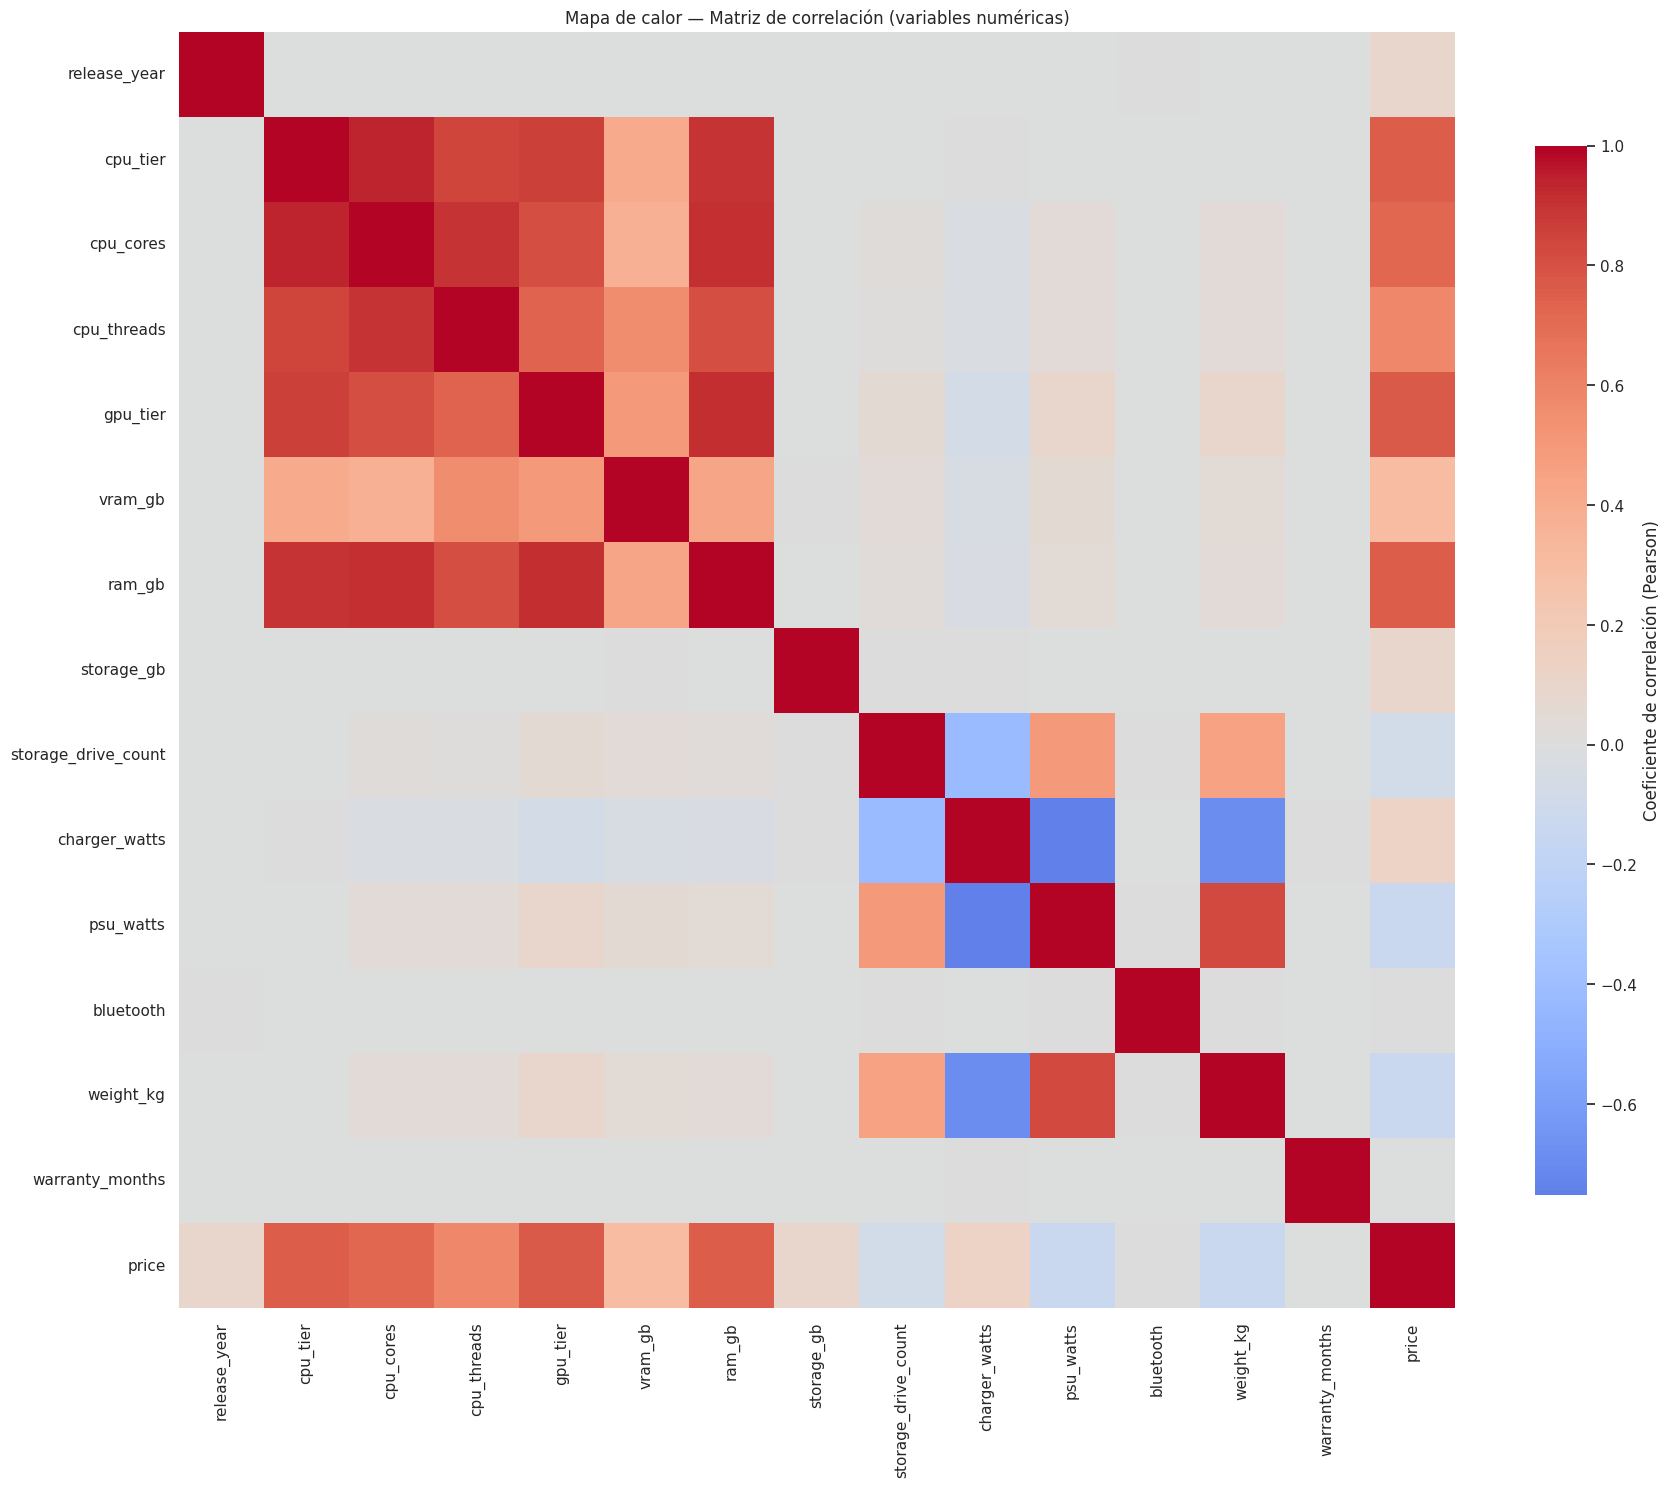


🔗 Pares con |correlación| > 0.9: 3
  -           cpu_tier  ~  cpu_cores           corr =  0.937
  -           gpu_tier  ~  ram_gb              corr =  0.913
  -          cpu_cores  ~  ram_gb              corr =  0.907

🧠 Criterio de selección (resumen):
 - Conservar variables que representan la capacidad general del hardware (CPU Tier, GPU Tier, RAM, Storage GB, Power Watts).
 - Eliminar variables con alta correlación (> 0.90) que sean redundantes o menos informativas (ej. cpu_threads si cpu_cores tiene menor rank).
 - En caso de empate en el ranking, conservar la variable con menos valores faltantes.
 - La variable 'price' (target) nunca se elimina.

🗑️ Variables eliminadas por alta correlación: ['cpu_cores', 'ram_gb']
✨ Variables numéricas conservadas: ['bluetooth', 'charger_watts', 'cpu_threads', 'cpu_tier', 'gpu_tier', 'price', 'psu_watts', 'release_year', 'storage_drive_count', 'storage_gb', 'vram_gb', 'warranty_months', 'weight_kg']

✅ Columnas eliminadas del DataFrame: ['cpu_co

In [6]:
import os
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


for col in ["model", "gpu_model"]:
    if col in compu_df.columns:
        compu_df.drop(columns=col, inplace=True, errors="ignore")

num_cols = compu_df.select_dtypes(include=[np.number]).columns.tolist()

if not num_cols:
    raise ValueError("No se detectaron columnas numéricas en el DataFrame.")

corr = compu_df[num_cols].corr(method='pearson', numeric_only=True)

plt.figure(figsize=(min(1.2*len(num_cols), 22), min(1.0*len(num_cols), 18)))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, square=True,
            cbar_kws={'shrink': 0.8, 'label': 'Coeficiente de correlación (Pearson)'})
plt.title("Mapa de calor — Matriz de correlación (variables numéricas)")
plt.tight_layout()
plt.show()

threshold = 0.90
pairs = []
cols = corr.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = corr.iat[i, j]
        if pd.notna(val) and abs(val) > threshold:
            pairs.append((cols[i], cols[j], float(val)))

pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)

print(f"\n🔗 Pares con |correlación| > {threshold}: {len(pairs_sorted)}")
if pairs_sorted:
    for a, b, v in pairs_sorted:
        print(f"  - {a:>18}  ~  {b:<18}  corr = {v: .3f}")
else:
    print("  (No se encontraron pares con esa correlación.)")

rank = {
    "price": 0,             # No se elimina el target
    "cpu_tier": 1,          # CPU: nivel resumen de desempeño
    "cpu_cores": 2,         # CPU: paralelo "duro" (preferible a threads)
    "cpu_threads": 6,       # Derivado de cores, suele ser múltiplo
    "gpu_tier": 3,          # GPU: nivel resumen de desempeño
    "vram_gb": 4,           # Complementa GPU, pero si es muy colineal con gpu_tier, preferimos gpu_tier
    "ram_gb": 5,            # Memoria principal (capacidad)
    "storage_gb": 7,        # Capacidad de almacenamiento
    "storage_drive_count": 12, # Menos representativa que capacidad total
    "psu_watts": 8,         # Potencia disponible (desktops)
    "charger_watts": 9,     # Potencia disponible (laptops)
    "release_year": 15,     # Proxy de generación, no "capacidad" directa
    "warranty_months": 20,   # No es capacidad de HW (corrected typo from warranty_month)
    "weight_kg": 30         # No es capacidad de HW
}
# Para columnas no listadas, asignar prioridad neutral
default_rank = 50

def get_rank(col):
    return rank.get(col, default_rank)

never_drop = {"price"}

to_drop = set()
kept = set()

non_null_counts = compu_df[num_cols].notna().sum()

for a, b, v in pairs_sorted:
    # Si alguna de las columnas ya fue marcada para eliminar o mantener, saltar
    if a in to_drop or b in to_drop or a in kept or b in kept:
        continue

    # Nunca eliminar el target
    if a in never_drop:
        kept.add(a)
        if b not in kept: to_drop.add(b) # Si b no es target y no la hemos decidido, la marcamos para eliminar
        continue
    if b in never_drop:
        kept.add(b)
        if a not in kept: to_drop.add(a) # Si a no es target y no la hemos decidido, la marcamos para eliminar
        continue


    ra, rb = get_rank(a), get_rank(b)
    if ra < rb:
        keep, drop = a, b
    elif rb < ra:
        keep, drop = b, a
    else:

        na = non_null_counts.get(a, 0)
        nb = non_null_counts.get(b, 0)
        if na >= nb:
            keep, drop = a, b
        else:
            keep, drop = b, a


    if keep not in to_drop:
        kept.add(keep)
    if drop not in kept:
        to_drop.add(drop)

to_drop = to_drop - kept

cols_eliminadas_por_corr = sorted(list(to_drop))
cols_conservadas_tras_corr = sorted(list(set(num_cols) - to_drop))


print("\n🧠 Criterio de selección (resumen):")
print(" - Conservar variables que representan la capacidad general del hardware (CPU Tier, GPU Tier, RAM, Storage GB, Power Watts).")
print(" - Eliminar variables con alta correlación (> 0.90) que sean redundantes o menos informativas (ej. cpu_threads si cpu_cores tiene menor rank).")
print(" - En caso de empate en el ranking, conservar la variable con menos valores faltantes.")
print(" - La variable 'price' (target) nunca se elimina.")

print(f"\n🗑️ Variables eliminadas por alta correlación: {cols_eliminadas_por_corr}")
print(f"✨ Variables numéricas conservadas: {cols_conservadas_tras_corr}")

if cols_eliminadas_por_corr:
    compu_df.drop(columns=cols_eliminadas_por_corr, inplace=True, errors="ignore")
    print(f"\n✅ Columnas eliminadas del DataFrame: {cols_eliminadas_por_corr}")
else:
    print("\nℹ️ No se encontraron columnas para eliminar por alta correlación.")

print(f"🔁 Nuevo shape tras eliminación por correlación: {compu_df.shape[0]} filas × {compu_df.shape[1]} columnas")

4. Para comenzar con la ingeniería de características, crea una copia del dataframe y asígnala a un nuevo objeto llamado `compu_trans`.
* Calcula cuántos años han pasado desde el lanzamiento de cada computadora y almacénalo en una nueva columna llamada `years_since_release`; luego, elimina la columna original.
* Utiliza `KBinsDiscretizer` para reemplazar la columna `vram_gb` en 4 bins ordinales basados en cuantiles.
* Imprime los valores que delimitan cada bin y haz un histograma para ver la cantidad de observaciones en cada uno, con el fin de entender cómo se agruparon los datos.

Límites de los 4 bins (cuantiles) para vram_gb:
Bin 0: 0.00  →  4.00
Bin 1: 4.00  →  6.00
Bin 2: 6.00  →  8.00
Bin 3: 8.00  →  16.00


/tmp/ipython-input-4015116518.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='vram_gb_bins', data=compu_trans, palette='viridis')


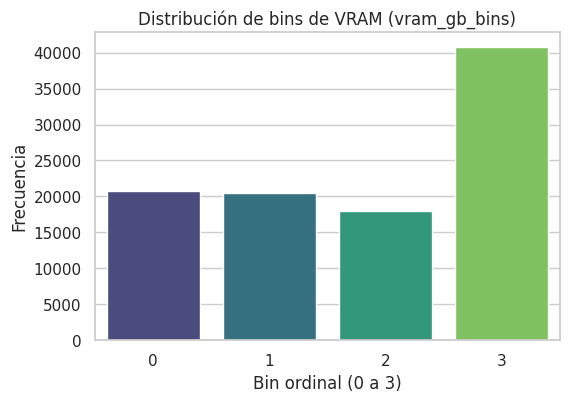

In [7]:
from datetime import datetime
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import seaborn as sns

# Copia para transformaciones
compu_trans = compu_df.copy()

# Obtener año actual
anio_actual = datetime.now().year

# Crear la nueva columna
compu_trans['years_since_release'] = anio_actual - compu_trans['release_year']

# Eliminar columna original
compu_trans.drop(columns=['release_year'], inplace=True)
compu_trans[['years_since_release']].head()

# Instanciar con 4 bins y estrategia de cuantiles
kbins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

# Ajustar y transformar
compu_trans['vram_gb_bins'] = kbins.fit_transform(compu_trans[['vram_gb']]).astype(int)

# Obtener los valores que delimitan los bins
bin_edges = kbins.bin_edges_[0]
print("Límites de los 4 bins (cuantiles) para vram_gb:")
for i in range(len(bin_edges) - 1):
    print(f"Bin {i}: {bin_edges[i]:.2f}  →  {bin_edges[i+1]:.2f}")

# Eliminar columna original
compu_trans.drop(columns=['vram_gb'], inplace=True)

plt.figure(figsize=(6,4))
sns.countplot(x='vram_gb_bins', data=compu_trans, palette='viridis')
plt.title("Distribución de bins de VRAM (vram_gb_bins)")
plt.xlabel("Bin ordinal (0 a 3)")
plt.ylabel("Frecuencia")
plt.show()


5. Observa los histogramas del ejercicio 2. Notarás que en las variables `charger_watts` y `psu_watts` aparece una barra en 0. Analiza por qué ocurre esto y qué significa en relación con el tipo de dispositivo.
* Como estas variables son mutuamente excluyentes, combínalas en una nueva columna llamada `power_watts` que contenga la potencia correspondiente de cada dispositivo y, a continuación, haz un histograma para verificar que la distribución resultante es bimodal.
* Por último, borra las columnas originales `charger_watts` y `psu_watts`.

Porcentaje de ceros:
{'charger_watts==0': np.float64(0.40156), 'psu_watts==0': np.float64(0.59844)}
Filas donde AMBAS son 0 (deberían ser ~0): 0
power_watts creada. Ejemplos:


,device_type,charger_watts,psu_watts,power_watts
0,Desktop,0,750,750
1,Laptop,120,0,120
2,Desktop,0,850,850
3,Desktop,0,650,650
4,Laptop,90,0,90


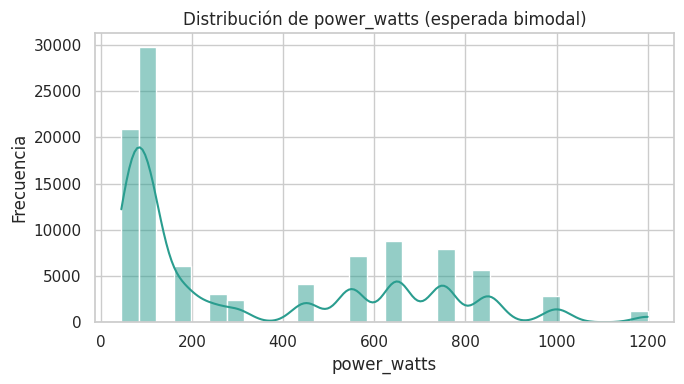

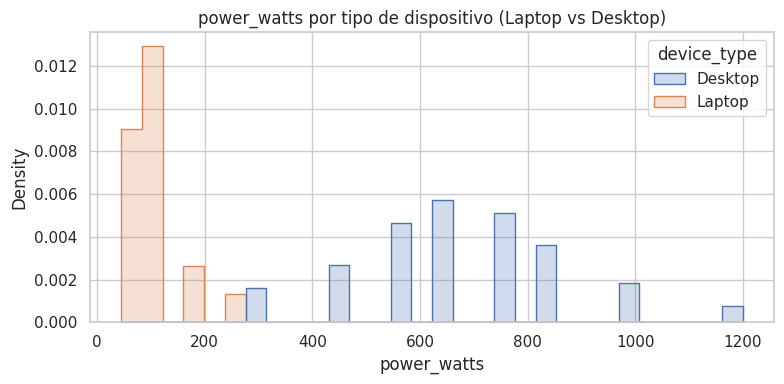

Shape actual: (100000, 21)


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = compu_trans

# ¿por qué hay tantos ceros?
print("Porcentaje de ceros:")
print({
    "charger_watts==0": (df["charger_watts"] == 0).mean(),
    "psu_watts==0": (df["psu_watts"] == 0).mean()
})
print("Filas donde AMBAS son 0 (deberían ser ~0):",
      ((df["charger_watts"] == 0) & (df["psu_watts"] == 0)).sum())

# power_watts combinando variables (si charger_watts > 0 usa ese; si no, usa psu_watts)
df["power_watts"] = df["charger_watts"].where(df["charger_watts"] > 0, df["psu_watts"])

# Validación
assert df["power_watts"].isna().sum() == 0, "Aparecieron NaN en power_watts"
print("power_watts creada. Ejemplos:")
display(df[["device_type", "charger_watts", "psu_watts", "power_watts"]].head())

# Verificar bimodalidad (histograma + KDE)
plt.figure(figsize=(7,4))
sns.histplot(df["power_watts"], bins=30, kde=True, color="#2a9d8f")
plt.title("Distribución de power_watts (esperada bimodal)")
plt.xlabel("power_watts")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# separación por tipo de dispositivo
plt.figure(figsize=(8,4))
sns.histplot(data=df, x="power_watts", hue="device_type", bins=30, element="step", stat="density", common_norm=False)
plt.title("power_watts por tipo de dispositivo (Laptop vs Desktop)")
plt.xlabel("power_watts")
plt.tight_layout()
plt.show()

# Columnas originales
df.drop(columns=["charger_watts", "psu_watts"], inplace=True)
print("Shape actual:", df.shape)


6. Para disminuir el sesgo de la variable `price`, crea tres transformadores: logaritmo, raíz cuadrada y Box - Cox.
* Aplica cada transformador a la variable price, dejando el resultado en variables temporales. El objetivo es comparar los efectos de cada transformación antes de decidir cuál aplicar de manera definitiva sobre las variables continuas del dataframe.
* De la variable original y de cada una de las tres transformaciones se debe mostrar:
  * Histograma: para observar la distribución de los datos.
  * Boxplot: para identificar posibles valores atípicos.
  * Q-Q plot: para evaluar la normalidad de la variable.
  * Skew (sesgo): para cuantificar la asimetría de la distribución.
  * Cantidad de outliers: para conocer cuántos valores extremos existen.
* En función de los resultados obtenidos al comparar las transformaciones, decide cuál logró el mejor efecto sobre la distribución de la variable y aplícala directamente en el dataframe, reemplazando las variables continuas: `weight_kg`, `power_watts` y `price`.

In [9]:
import numpy as np
from scipy import stats

# 1Verificar valores mínimos de price
min_price = compu_trans['price'].min()
print("Valor mínimo de price:", min_price)

# Si hay ceros o negativos, ajustamos para Box-Cox
if min_price <= 0:
    compu_trans['price_adj'] = compu_trans['price'] + abs(min_price) + 1
    print("Se creó price_adj para Box-Cox (ajustado).")
    price_for_boxcox = compu_trans['price_adj']
else:
    price_for_boxcox = compu_trans['price']

# Transformación logarítmica
compu_trans['price_log'] = np.log(compu_trans['price'] + 1)

# Transformación raíz cuadrada
compu_trans['price_sqrt'] = np.sqrt(compu_trans['price'])

# Transformación Box-Cox
compu_trans['price_boxcox'], lambda_boxcox = stats.boxcox(price_for_boxcox)
print("Lambda usado en Box-Cox:", lambda_boxcox)

compu_trans[['price', 'price_log', 'price_sqrt', 'price_boxcox']].head()

Valor mínimo de price: 372.99
Lambda usado en Box-Cox: 0.15041805793433355


,price,price_log,price_sqrt,price_boxcox
0,1383.99,7.233448,37.202016,13.084409
1,2274.99,7.730170,47.696855,14.616126
2,1879.99,7.539554,43.358851,14.014803
3,1331.99,7.195180,36.496438,12.971066
4,2681.99,7.894687,51.787933,15.149121



Análisis de: Original (price)
Skew (sesgo): 0.9866
Cantidad de outliers: 976


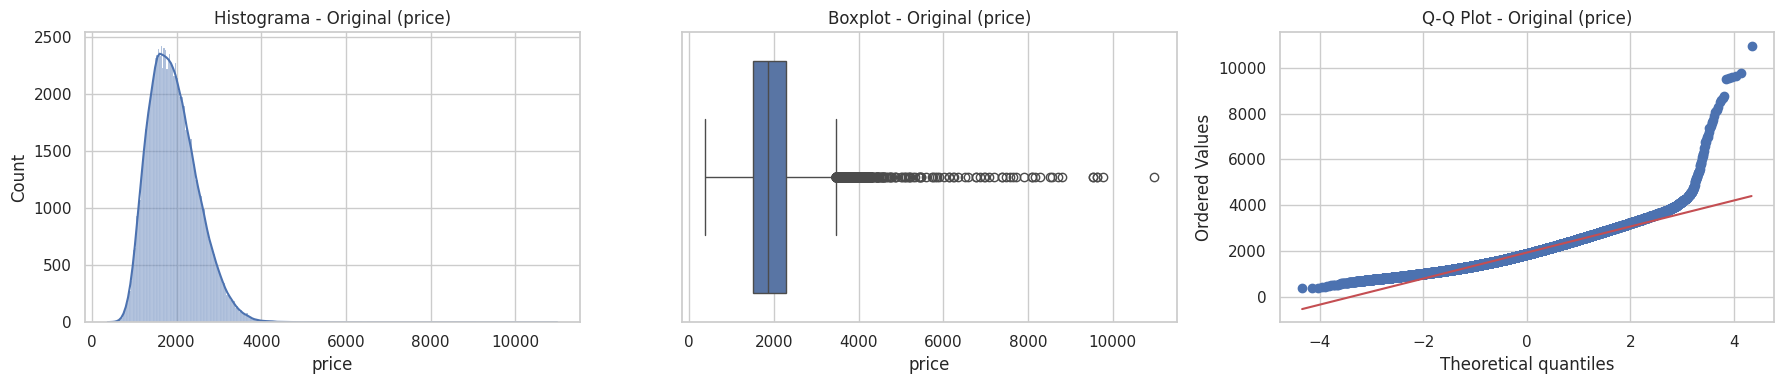


Análisis de: Log (price_log)
Skew (sesgo): -0.1326
Cantidad de outliers: 387


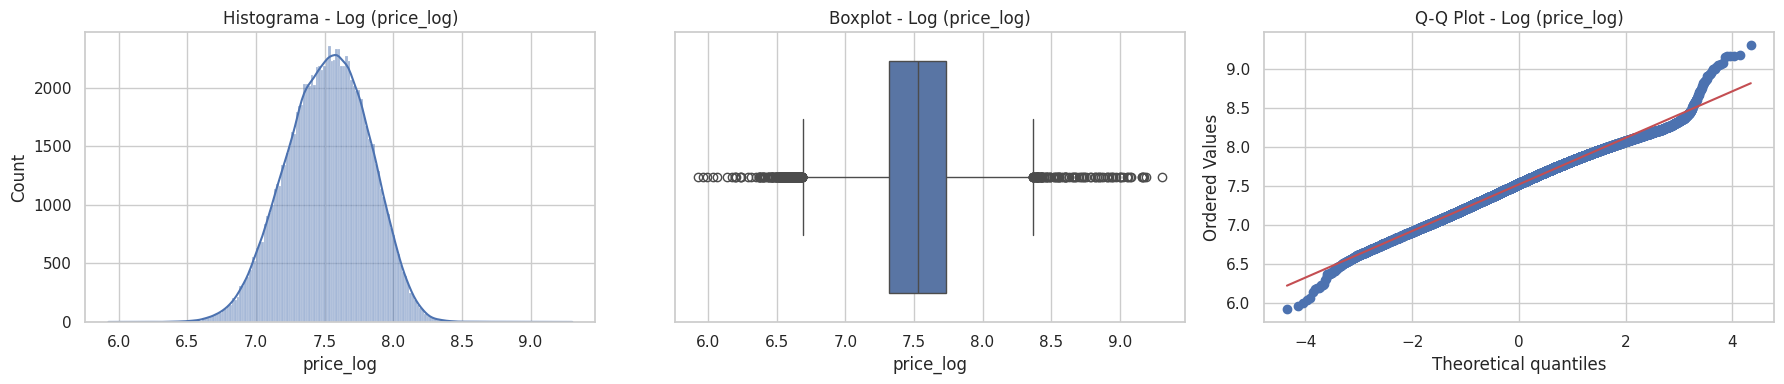


Análisis de: Raíz cuadrada (price_sqrt)
Skew (sesgo): 0.3323
Cantidad de outliers: 364


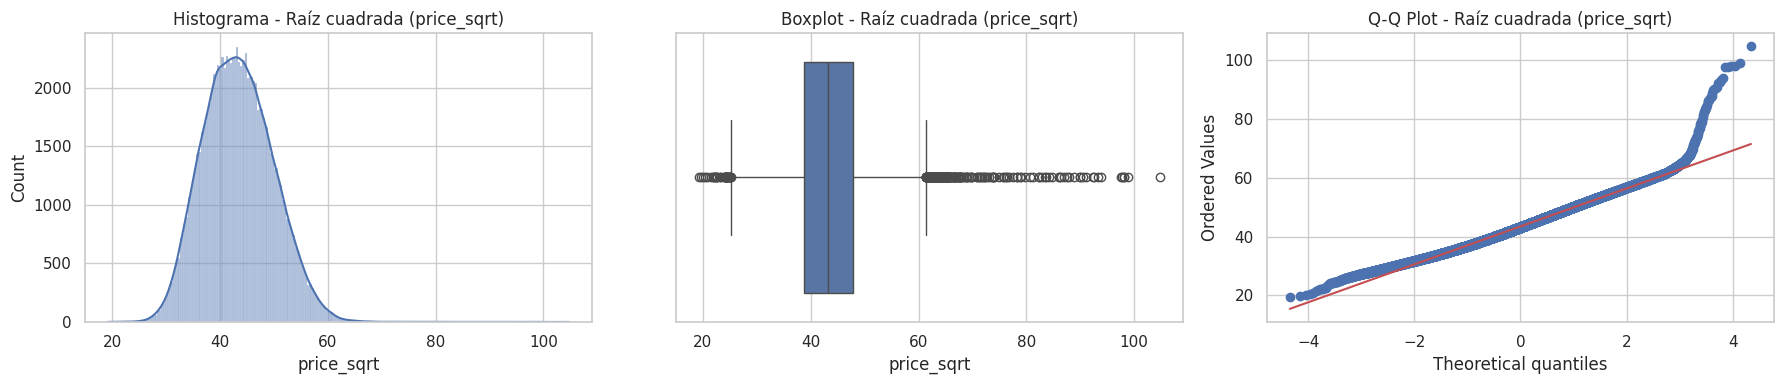


Análisis de: Box-Cox (price_boxcox)
Skew (sesgo): -0.0002
Cantidad de outliers: 317


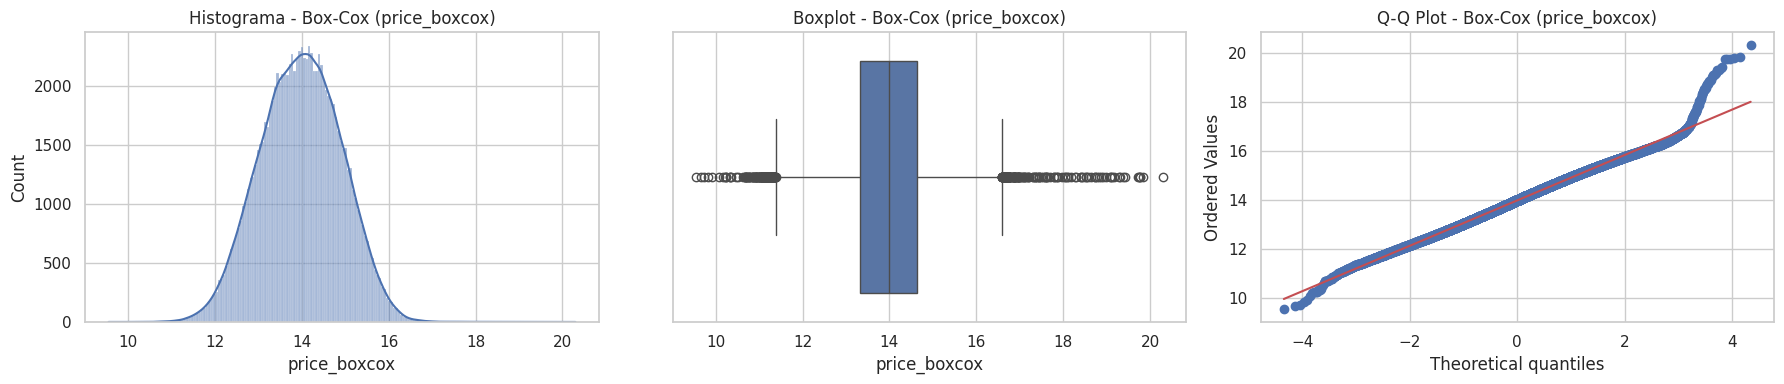

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Lista de variables a analizar
vars_to_plot = {
    'Original (price)': compu_trans['price'],
    'Log (price_log)': compu_trans['price_log'],
    'Raíz cuadrada (price_sqrt)': compu_trans['price_sqrt'],
    'Box-Cox (price_boxcox)': compu_trans['price_boxcox']
}

# Función para contar outliers usando IQR
def contar_outliers(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return ((serie < lim_inf) | (serie > lim_sup)).sum()

# Recorrer cada variable y graficar
for nombre, serie in vars_to_plot.items():
    print(f"\n==============================")
    print(f"Análisis de: {nombre}")
    print("==============================")

    skew_value = serie.skew()
    outliers = contar_outliers(serie)
    print(f"Skew (sesgo): {skew_value:.4f}")
    print(f"Cantidad de outliers: {outliers}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Histograma
    sns.histplot(serie, kde=True, ax=axes[0])
    axes[0].set_title(f"Histograma - {nombre}")

    # Boxplot
    sns.boxplot(x=serie, ax=axes[1])
    axes[1].set_title(f"Boxplot - {nombre}")

    # QQ Plot
    stats.probplot(serie, dist="norm", plot=axes[2])
    axes[2].set_title(f"Q-Q Plot - {nombre}")

    plt.tight_layout()
    plt.show()

In [11]:
import numpy as np
import pandas as pd

# Lista de variables a comparar
variables = ['price', 'price_log', 'price_sqrt', 'price_boxcox']

resultados = []

for var in variables:
    data = compu_trans[var]

    # Skewness
    skewness = data.skew()

    # Outliers usando IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()

    resultados.append({
        'Variable': var,
        'Skew': round(skewness, 6),
        'Outliers': outliers
    })

df_resultados = pd.DataFrame(resultados)
df_resultados

,Variable,Skew,Outliers
0,price,0.986644,976
1,price_log,-0.132601,387
2,price_sqrt,0.332253,364
3,price_boxcox,-0.000238,317


price: λ=0.150418, shift=0, min_before=372.99
weight_kg: λ=-0.480424, shift=0, min_before=0.92
power_watts: λ=-0.165033, shift=0, min_before=45

Métricas post-Box–Cox:
  price         skew=-0.00024  outliers=317
  weight_kg     skew=0.21375  outliers=0
  power_watts   skew=0.08658  outliers=0


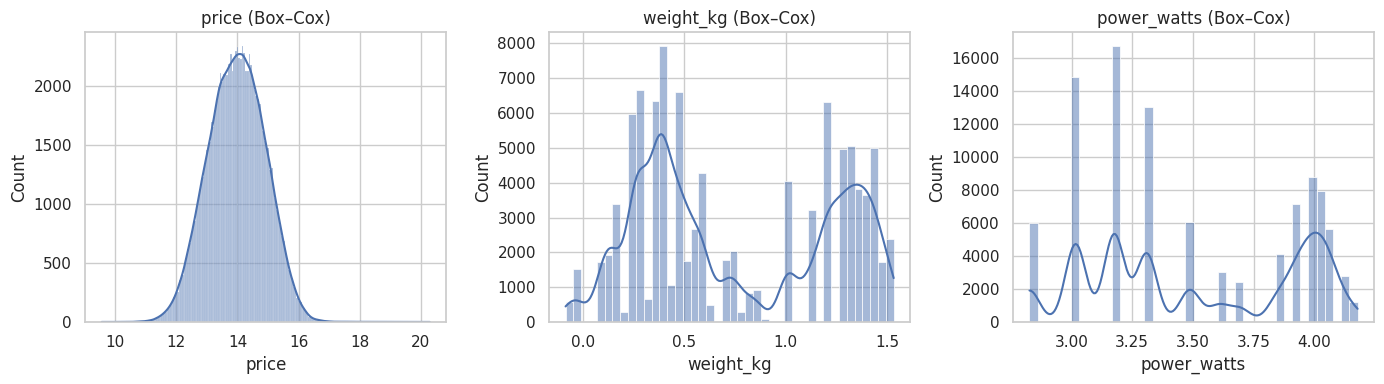

In [12]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = compu_trans

def boxcox_replace(df, col):
    x = df[col].astype(float).copy()
    xmin = x.min()
    shift = 0.0
    if xmin <= 0:
        shift = abs(xmin) + 1e-6
        x = x + shift
    x_bc, lam = stats.boxcox(x)
    df[col] = x_bc
    return {"lambda": lam, "shift": shift, "min_before": float(xmin)}

# Aplicar Box–Cox a las 3 continuas
bc_info = {}
for c in ["price", "weight_kg", "power_watts"]:
    info = boxcox_replace(df, c)
    bc_info[c] = info
    print(f"{c}: λ={info['lambda']:.6f}, shift={info['shift']:.6g}, min_before={info['min_before']:.6g}")

# Limpiar columnas temporales
for tmp in ["price_log", "price_sqrt", "price_boxcox", "price_adj"]:
    if tmp in df.columns:
        df.drop(columns=tmp, inplace=True)

def skew_outliers(s):
    Q1, Q3 = s.quantile(0.25), s.quantile(0.75)
    IQR = Q3 - Q1
    out = ((s < Q1 - 1.5*IQR) | (s > Q3 + 1.5*IQR)).sum()
    return s.skew(), out

print("\nMétricas post-Box–Cox:")
for c in ["price", "weight_kg", "power_watts"]:
    sk, out = skew_outliers(df[c])
    print(f"  {c:<12}  skew={sk:.5f}  outliers={out}")

fig, axes = plt.subplots(1, 3, figsize=(14,4))
for ax, c in zip(axes, ["price", "weight_kg", "power_watts"]):
    sns.histplot(df[c], kde=True, ax=ax)
    ax.set_title(f"{c} (Box–Cox)")
plt.tight_layout(); plt.show()

7. Para que todas las variables numéricas estén en la misma escala, aplica `MinMaxScaler` de sklearn a todas las columnas numéricas del dataframe, reemplazando las columnas originales.

8. Aunque `wifi` es una variable categórica, sus categorías tienen un orden natural (Wi-Fi 5 < Wi-Fi 6 < Wi-Fi 6E < Wi-Fi 7). Codifícala usando `OrdinalEncoder`.
* Luego, escala la variable codificada entre 0 y 1 con `MinMaxScaler`, para que quede en la misma escala que las variables numéricas del dataframe.

Nota: Ambos cambios deben efectuarse sobre la columna original, de manera que quede una única columna `wifi` con toda la información transformada.

9. La variable `gpu_model` tiene muchas categorías. Usar *One-Hot Encoding* aumentaría significativamente la dimensionalidad del dataframe. Por ello, utiliza `BinaryEncoder` para codificarla.
* Guarda el resultado en un dataframe llamado `bin_df`. Más adelante, lo combinarás con `compu_transf` para integrar las variables codificadas.

10. Usa `OneHotEncoder` para codificar las variables categóricas restantes. Asegúrate de usar `drop='first'` para evitar la multicolinealidad y guarda el resultado en un dataframe llamado `ohe_df`
* Combina el dataframe `compu_transf` con las variables categóricas que fueron codificadas en `bin_df` y `ohe_df`. No olvides eliminar las variables originales.
* Usa `describe()` sobre el dataframe resultante para corroborar que todas las columnas estén escaladas entre 0 y 1 y que no queden variables categóricas sin codificar.